In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
from pathlib import Path
from tqdm.rich import tqdm
import pandas as pd
from icecream import ic
import yaml
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

daimon_colors = ["#F0741E", "#276CB3"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffff", daimon_colors[1]])
yolo_model = "yolov10n"

In [2]:
def smooth(y, f=0.05):
    """Box filter of fraction f."""
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = np.ones(nf // 2)  # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode="valid")  # y-smoothed

1.0 at confidence 0.92992992992993


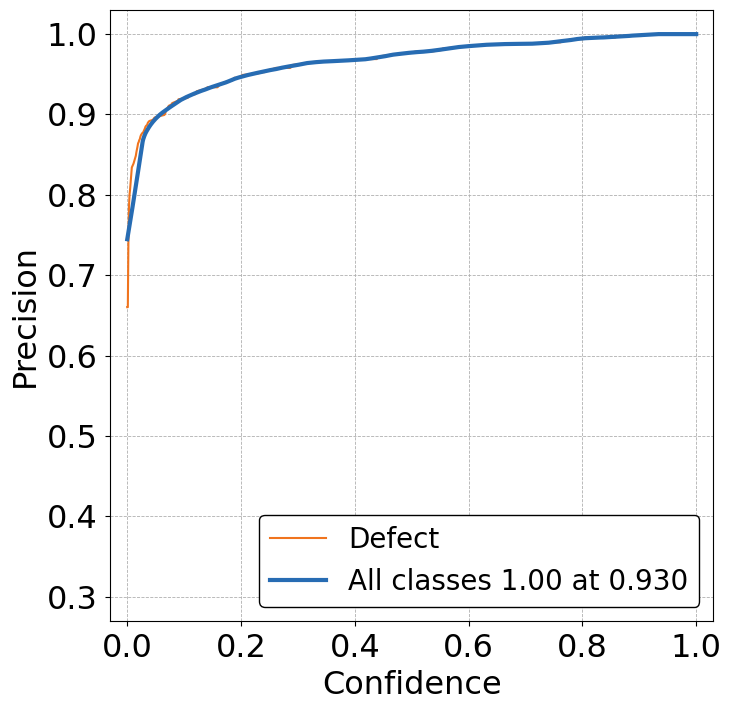

1.0 at confidence 0.0


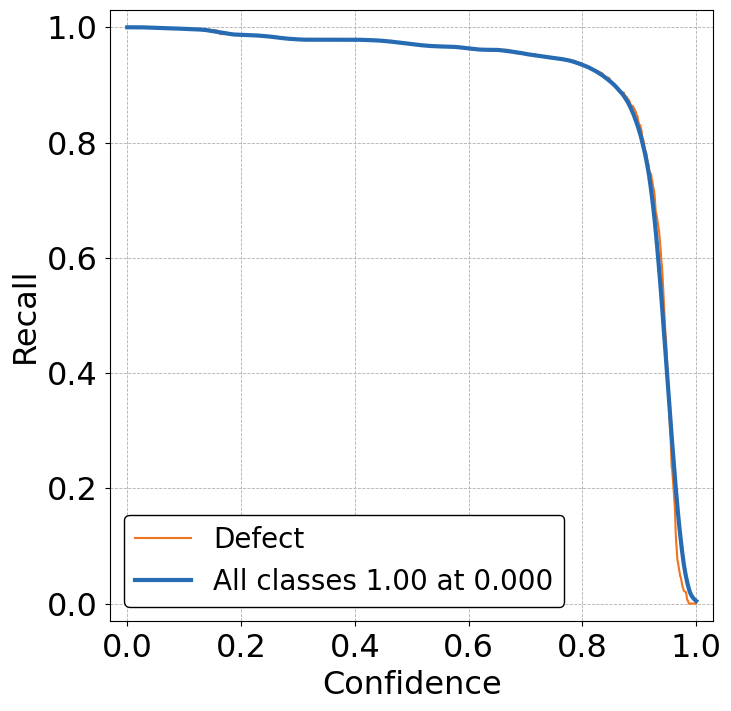

0.9745743150756635 at confidence 0.5795795795795796


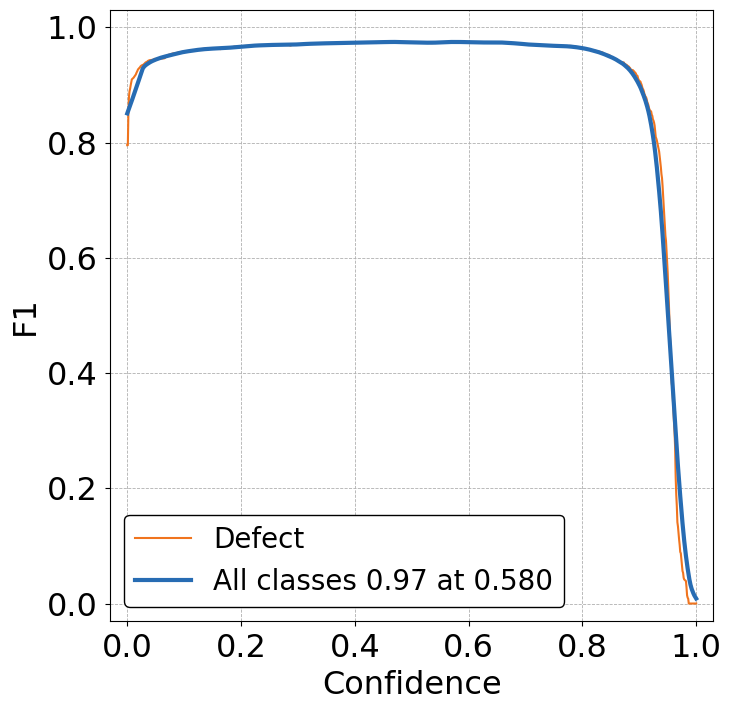

In [3]:
targets = ["P", "R", "F1"]
target_labels = {"P": "Precision", "R":"Recall","F1": "F1"}

for target in targets:
    df = pd.read_csv(f"./results_{yolo_model}/metrics/{target}_curve.csv")

    py = df[f'{target_labels[target]}_Defect'].values
    df[f"{target_labels[target]}_all"] = smooth(py, 0.05)

    Max_y = df[f"{target_labels[target]}_all"].max()  # valore massimo di y
    Max_x = df['Confidence'][df[f"{target_labels[target]}_all"].idxmax()]  # corrispondente valore di x
    
    print(f"{Max_y} at confidence {Max_x}")

    # Impostazione dello stile per un layout professionale
    plt.style.use("seaborn-v0_8-paper")

    # Creazione del grafico
    plt.figure(figsize=(7, 7))


    # Plot con Seaborn
    sns.lineplot(x='Confidence', y=f'{target_labels[target]}_Defect', data=df, label='Defect', color=daimon_colors[0], linewidth=1.5)
    sns.lineplot(x='Confidence', y=f'{target_labels[target]}_all', data=df, label=f'All classes {Max_y:.2f} at {Max_x:.3f}', color=daimon_colors[1], linewidth=3)

    # Personalizzazione
    plt.xlabel('Confidence', fontsize=23)
    plt.ylabel(f'{target_labels[target]}', fontsize=23)
    if target == "P":
        legend = plt.legend(loc='lower right', fontsize=20,edgecolor='black',framealpha=1.0)
    else:
        legend = plt.legend(loc='lower left', fontsize=20,edgecolor='black',framealpha=1.0)
        
    legend.get_frame().set_linewidth(1)

    # Aggiunta di una griglia leggera
    #plt.grid(True, which='both', linestyle='--', linewidth=0.6,color='black', alpha=0.6)
    plt.grid(True, which='both', linestyle='--', linewidth=0.6)
    plt.xlim((-0.03,1.03))
    plt.ylim(top=1.03)
    if target == "P":
        plt.ylim(bottom=0.27)
    else:
        plt.ylim(bottom=-0.03)


    # Salva la figura con alta risoluzione
    plt.tight_layout()
    plt.tick_params(axis="both", which="major", labelsize=23)
    plt.savefig(
            f"./results_{yolo_model}/metrics/plots/{target}_curve.png",
            dpi=300,
            bbox_inches="tight",
        )

    # Mostrare il grafico
    plt.show()


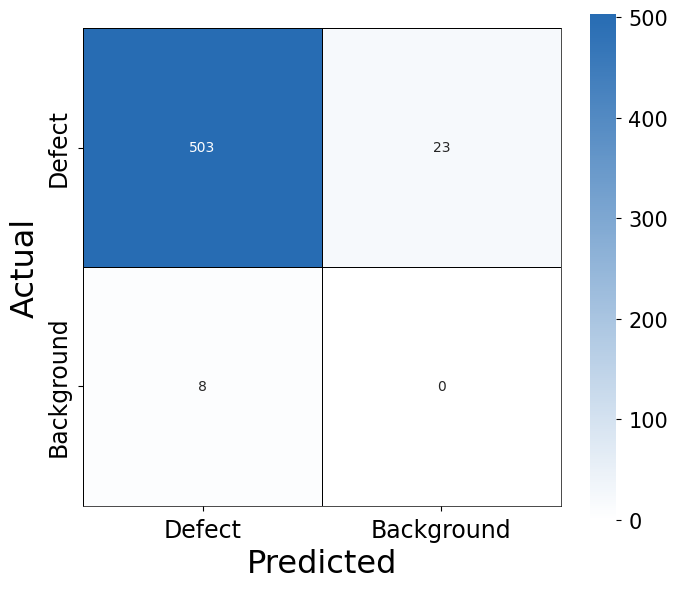

In [4]:
with open(f"./results_{yolo_model}/metrics/confusion_matrix.txt", 'r') as f:
    data = f.readlines()
    
labels = ['Defect', 'Background']

# Trasforma i dati in una matrice 2x2
confusion_matrix = []
for line in data:
    row = list(map(float, line.split()))  # converte in float ogni numero
    confusion_matrix.append(row)

confusion_matrix = np.array(confusion_matrix).astype(int)

# Plot della confusion matrix
plt.figure(figsize=(7, 6))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap, cbar=True,linewidths=0.5, linecolor='black',square=True,vmin=0, vmax=np.max(confusion_matrix))
plt.xlabel("Predicted", fontsize=23)
plt.ylabel("Actual", fontsize=23)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

ax.set_xticklabels(labels, fontsize=17)
ax.set_yticklabels(labels, fontsize=17)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.5) 

plt.tight_layout()
plt.tick_params(axis="both", which="major")
plt.savefig(
    f"./results_{yolo_model}/metrics/plots/cmatrix.png",
    dpi=300,
    bbox_inches="tight",
)
